![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Wind Chill Index with Reanalysis Data

This tutorial will demonstrate how to combine multiple variables of climate data to create an index.
The data is provided by [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/) and includes regional climate reanalysis data (UERRA) of wind speed and temperature over Europe from 1961 to 2019.

The tutorial will first show how to download the necessary data from the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/). It will then describe how to apply a commonly used Wind Chill Index formula to the data, and finally plot a map of the wind chill climatology for a particular day over Europe.

The steps shown in this tutorial can be applied to many other types of sigle or multi-variable indices and other climate datasets, such as the 5th version of the ECMWF Reanalysis (ERA5), or other data.

![logo](./img/climate_indices.png)

<hr>

## Learning objectives 🧠

1. Understanding how multiple variables can be combined to create a climate index.
   
2. Learning to apply an index formula to climate data.

4. Getting familiarized with how to visualize a climate index in a particular region and time frame.

<hr>

## Target audience 🎯

**Anyone** interested in computing climate indexes from C3S data and in visualizing it.

<hr>

## Prerequisites and assumed knowledge 🔍
1. **Basic Programming Skills**: Familiarity with programming concepts, particularly in Python, as the tutorial involves using Python libraries like [xarray](https://matplotlib.org/) for dealing with multidimensional arrays and [matplotlib](https://matplotlib.org/) to make visualisations.
   
2. **Familiarity with API Usage**: Understanding of how to use Application Programming Interfaces (APIs) will be useful for accessing data through the CDS API.

3. **Familiarity with multidimensional data structure**: Comprehending what are data dimensions and how they are organized in an array will be helpful.

<hr>

:::{admonition} Difficulty
:class: tip
2/5
:::

<hr>

:::{dropdown} Run the tutorial
:open:
### WEKEO

[WEkEO](https://www.wekeo.eu/) serves as the official platform of the European Centre for Medium-Range Weather Forecasts (ECMWF), offering access to an extensive array of climate data and tools for analysis and visualization. It provides a robust environment for conducting in-depth analysis and exploration of climate-related datasets. To learn more about WEkEO and its offerings, visit their [website](https://www.wekeo.eu/).

[Run this notebook on WEKEO](https://www.wekeo.eu/) 

### Possible Cloud Services

While Kaggle, Binder, and Colab are popular options for running notebooks in the cloud, it's essential to note that these are just a few among many available choices. Each platform has its unique features and capabilities, catering to diverse user needs and preferences.



| **Kaggle** | **Binder** | **Colab** |
|:----------:|:---------:|:--------:|
| [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Randbee/ci-windchill/blob/master/ci-windchill.ipynb) | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Randbee/ci-windchill.git/master?labpath=ci-windchill.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Randbee/ci-windchill/blob/master/ci-windchill.ipynb) |
:::

<hr>

## Outline

1. Libraries
    1. Install the necessary libraries
    2. Import the necessary libraries
2. Access data with the CDS API
3. Inspect data
4. Calculate wind chill index
5. Visualise average wind chill over Europe
6. Exercise: Repeat process with ERA5 data and compare results

<hr>

## 1. Libraries

### 1.A. Install the necessary libraries

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    Note the exclamation mark in the lines of code below. This means the code will run as a shell (as opposed to a notebook) command.</div>

If you still haven't done it, you will need to install the Application Programming Interface (API) of the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home). This will allow us to programmatically download data.

In [1]:
!pip install cdsapi

Check the libraries that will be imported in section 1.B. If you haven't got any of them installed yet, do it adapting the code above. Some libraries depend on other packages to work. [xarray](https://docs.xarray.dev/en/stable/), for example, depends on [numpy](https://numpy.org/) and [pandas](https://pandas.pydata.org/). As we are using xarray for reading netCDF files, we will need the [netCDF4](https://github.com/Unidata/netcdf4-python) dependency:

In [1]:
!pip install netCDF4

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For the netCDF4 installation to take effect, you must restart you Kernel (check the Kernel tab in your menu bar above).</div>

<hr>

### 1.B. Import the necessary libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular [xarray]((https://docs.xarray.dev/en/stable/)). We will also need libraries for plotting and viewing data, in this case we will use [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/).

In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

<hr>

## 2. Access data with the CDS API

### Enter your CDS API key

To access data from the CDS, you will need first to [register](https://cds.climate.copernicus.eu/#!/home) at the ADS registration page (if you haven't already done so), [log in](https://cds.climate.copernicus.eu/user/login), and accept the Terms and Conditions at the end of the `Download data` tab.<br>

To obtain data programmatically from the CDS, you will need an API Key that can be found in the [api-how-to page](https://cds.climate.copernicus.eu/api-how-to). Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS. Your API key is the entire string of characters that appears after `key:`

Now copy your API key into the code cell below, replacing `#######` with your key.

In [3]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##############'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
DATADIR = './'

### Search for data

The wind chill index we will calculate takes two parameters as input, these are 2m near-surface air temperature, and 10m wind speed. Data for these parameters are available as part of the [UERRA regional reanalysis for Europe on single levels from 1961 to 2019](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-uerra-europe-single-levels?tab=overview). You must search for this dataset on the [CDS website](http://cds.climate.copernicus.eu).

Having selected the dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Origin: `UERRA-HARMONIE`
- Variable: `10m wind speed` and `2m temperature` (these will need to be selected one at a time)
- Year: `1989 to 2018`
- Month: `January`
- Day: `15`
- Time: `06:00`
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cells below). You will do this twice: once for 10m wind speed and again for 2m temperature.

### Download data

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, remember to accept the **terms and conditions** of this particular dataset at the end of the `Download Form`, just above the `Show API request` option.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    UERRA data are stored on tapes in MARS, the ECMWF Meteorological Archival and Retrieval System. Accessing data from tapes is generally slower than accessing data directly from disk. The data requests below may take some hours to complete. For a quicker response you can replace the UERRA data request with similar download parameters for lower resolution ERA5 global reanalysis datasets.</div>
    

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'reanalysis-uerra-europe-single-levels',
    {
        'origin': 'uerra_harmonie',
        'variable': '10m_wind_speed',
        'year': [
            '1989', '1990', '1991',
            '1992', '1993', '1994',
            '1995', '1996', '1997',
            '1998', '1999', '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014', '2015',
            '2016', '2017', '2018',
        ],
        'month': '01',
        'day': '15',
        'time': '06:00',
        'format': 'netcdf',
    },
    f'{DATADIR}UERRA_ws10m.nc')

2024-07-09 11:38:53,624 INFO Welcome to the CDS
2024-07-09 11:38:53,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-uerra-europe-single-levels
2024-07-09 11:38:53,736 INFO Request is queued
2024-07-09 11:39:07,200 INFO Request is running


In [8]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'reanalysis-uerra-europe-single-levels',
    {
        'origin': 'uerra_harmonie',
        'variable': '2m_temperature',
        'year': [
            '1989', '1990', '1991',
            '1992', '1993', '1994',
            '1995', '1996', '1997',
            '1998', '1999', '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014', '2015',
            '2016', '2017', '2018',
        ],
        'month': '01',
        'day': '15',
        'time': '06:00',
        'format': 'netcdf',
    },
    f'{DATADIR}UERRA_t2m.nc')

2024-04-10 10:42:05,964 INFO Welcome to the CDS
2024-04-10 10:42:05,964 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-uerra-europe-single-levels
2024-04-10 10:42:06,081 INFO Request is queued
2024-04-10 10:42:14,467 INFO Request is running
2024-04-10 10:42:27,295 INFO Request is completed
2024-04-10 10:42:27,296 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data7/adaptor.mars.external-1712738538.660552-19127-12-9e45a825-278c-4528-bf12-8c9fa885d478.nc to ./UERRA_t2m.nc (41.4M)
2024-04-10 10:42:51,742 INFO Download rate 1.7M/s                               


Result(content_length=43436669,content_type=application/x-netcdf,location=https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data7/adaptor.mars.external-1712738538.660552-19127-12-9e45a825-278c-4528-bf12-8c9fa885d478.nc)

<hr>

## 3. Inspect data

We have requested the data in `NetCDF` format. To read and process this data we will make use of the [xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) objects.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    You can find more detailed information on multi-dimensional arrays in the tutorial on <a href="https://randbee.github.io/C3SBook/notebooks/reanalysis-climatology/reanalysis-climatology.html">climatology reanalysis</a>.
</div>

In [9]:
fw = 'UERRA_ws10m.nc'
ft = 'UERRA_t2m.nc'
# Create Xarray Dataset
dw = xr.open_dataset(fw)
dt = xr.open_dataset(ft)

Now we can query our newly created Xarray datasets ...

In [10]:
dw

<xarray.Dataset>
Dimensions:            (time: 30, y: 565, x: 565)
Coordinates:
  * time               (time) datetime64[ns] 1989-01-15T06:00:00 ... 2018-01-...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         (time) datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    si10               (time, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2024-04-10T08:41 GRIB to CDM+CF via cfgrib-0.9.9...

We see that dw (dataset for wind speed) has one variable called **"si10"**. If you view the documentation for this dataset on the CDS you will see that this is the wind speed valid for a grid cell at the height of 10m above the surface. It is computed from both the zonal (u) and the meridional (v) wind components by $\sqrt{(u^{2} + v^{2})}$. The units are m/s.

The other dataset, dt (2m temperature), has a variable called **"t2m"**. According to the documentation on the CDS this is air temperature valid for a grid cell at the height of 2m above the surface, in units of Kelvin.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **si10** and **t2m** data easier, we will convert them into Xarray data arrays.

In [11]:
# Create Xarray Data Arrays
aw = dw['si10']
at = dt['t2m']

In [12]:
aw

<xarray.DataArray 'si10' (time: 30, y: 565, x: 565)>
array([[[7.111225, 7.133708, ..., 3.765304, 3.713747],
        [7.117136, 7.133363, ..., 3.767574, 3.717258],
        ...,
        [6.02359 , 6.060655, ..., 3.697788, 3.380661],
        [5.779871, 5.850547, ..., 3.705701, 3.389646]],

       [[7.949655, 7.993507, ..., 5.186105, 5.083971],
        [8.047757, 8.082835, ..., 5.141717, 5.040252],
        ...,
        [5.97837 , 6.03528 , ..., 4.481109, 4.550926],
        [5.761007, 5.81558 , ..., 4.354814, 4.423597]],

       ...,

       [[5.580364, 5.571821, ..., 1.800079, 1.689157],
        [5.576257, 5.566843, ..., 1.807214, 1.696283],
        ...,
        [8.214161, 8.383091, ..., 6.844867, 6.770612],
        [8.040735, 8.191771, ..., 6.873119, 6.754093]],

       [[7.267553, 7.254709, ..., 6.03502 , 5.987562],
        [7.359537, 7.349123, ..., 6.152757, 6.105344],
        ...,
        [9.339788, 9.402693, ..., 4.116365, 4.467954],
        [8.992914, 9.08951 , ..., 4.445055, 4.754884]]], dtype=float32)
Coordinates:
  * time               (time) datetime64[ns] 1989-01-15T06:00:00 ... 2018-01-...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         (time) datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes: (12/33)
    GRIB_paramId:                             207
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      319225
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

Notice that the `longitude` variables in the Xarray Dataset and Data Array objects are in the range of `[0, 359.75]`. Let us convert them into a `[-180, 180]` grid:

In [13]:
aw['longitude'] = ((aw.longitude + 180) % 360) - 180
at['longitude'] = ((at.longitude + 180) % 360) - 180

<hr>

## 4. Calculate wind chill index

The wind chill index is a metric in temperature-like units, e.g. Kelvin or °C, and represents the lowering of body temperature due to a combination of low temperature and wind.

Since 2001, Canada, the United States and the United Kingdom have implemented the new wind chill index which is defined with the following formula:

$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

where:
- $\textit{T}_{WC}$ = wind chill index
- $\textit{T}_{a}$ = air temperature in degrees Celsius
- $\upsilon$ = wind speed at 10 m standard anemometer height, in kilometres per hour

We will apply this formula on our data to calculate the wind chill index for a particular period of time over Europe.

To calculate $\textit{T}_{WC}$ we first have to ensure our data is in the right units. For the wind speed we need to convert from m/s to km/h, and for air temperature we need to convert from Kelvin to degrees Celsius:

**Wind speed:** Convert from m/s to km/h: `si10 * 1000 / (60*60)`

In [14]:
w = aw * 3600 / 1000

**Air temperature:** Convert from Kelvin to Celsius: `t2m - 273.15`

In [15]:
t = at - 273.15

Now we can calculate the North American and United Kingdom wind chill index:
$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

In [16]:
twc = 13.12 + (0.6215*t) - (11.37*(w**0.16)) + (0.3965*t*(w**0.16))

Let's calculate the average wind chill for 06:00 on 15 January for the 30 year period from 1989 to 2018:

In [17]:
twc_mean = twc.mean(dim='time')

Before we plot the results, let's take the same European subset as that used for the [C3S Climate Bulletins](https://climate.copernicus.eu/climate-bulletins).

In [18]:
twc_mean_sub = twc_mean.where((twc_mean.latitude < 72) & 
                              (twc_mean.latitude > 34) & 
                              (twc_mean.longitude < 40) & 
                              (twc_mean.longitude > -25), drop=True)

<hr>

## 5. Visualise average wind chill over Europe

Now let's plot the average wind chill for this time over Europe:

/home/randbee-user/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


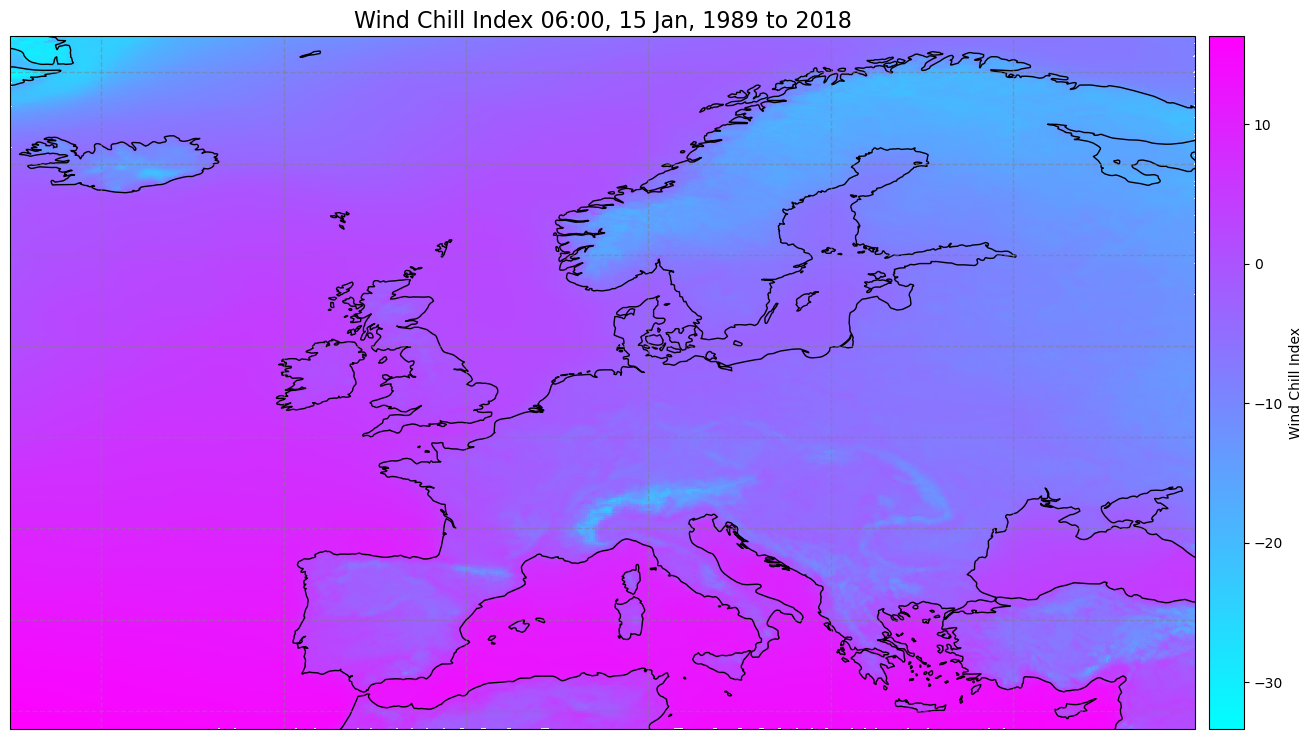

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (18, 9), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(twc_mean_sub.longitude, twc_mean_sub.latitude, twc_mean_sub, cmap='cool') 

ax.set_title('Wind Chill Index 06:00, 15 Jan, 1989 to 2018', fontsize=16)
ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.04, pad=0.01)
cbar.set_label('Wind Chill Index') 

fig.savefig(f'{DATADIR}UERRA_wind_chill_index_midJan.png')

Under which category of the wind chill index do the coldest areas in Europe generally lie at this time (see chart below)?

![logo](./img/Windchill_effect_en.svg)

RicHard-59, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons

<hr>

## 6. Exercise: Repeat process with ERA5 data and compare results

So far you have plotted wind chill using the UERRA regional reanalysis dataset, but how accurate is this plot? One way to assess a dataset is to compare it with an alternative independent one to see what differences there may be. An alternative to UERRA is the ECMWF Reanalysis datasets, ERA5 (currently in it's 5th version). Repeat the steps above with ERA5 data and compare your results with those obtained using UERRA.

<hr>

## Key Messages to Take Home 📌

- Climate indexes are metrics defined by formulas that include climate variables. The wind chill index, for example, is calculated from a formula that includes the variables wind speed and air temperature.

- Climate indexes can be calculated and visualised over specific regions and averaged over time.

<hr>